*SIO221a Notes - Alford and Gille*

*Reading: Bendat and Piersol, Ch. 5.2.1*

Concepts covered: Relationship between autocovariance and the spectrum, alternate methods of computing spectra

## Lecture 13

*Recap*

We've looked at several strategies for computing spectra and estimating degrees of freedom---segmenting data and computing the periodogram (the Fourier transform; Welch's method) or computing the periodogram (Fourier transform) and then averaging in frequency (Danziell's method).  Now, let's look at this from a different angle by considering the covariance.

Let's recall our notes from Lecture 8.  Formally the notation for a convolution of two records $h$ and $x$ is written

$$
h* x = \int_{-\infty}^\infty h(\tau)x(t - \tau) d\tau.
$$

And in the following lecture we discussed the autocovariance, which is the convolution of a record with its time-flipped self:
$$\begin{equation}
R_{xx}(\tau) = \int_{-\infty}^{\infty} x(t) x(\tau+t) dt.
\end{equation}$$

And since the autovariance is symmetric (i.e., $R_{xx}(\tau)=R_{xx}(-\tau)$),

$$\begin{equation}
R_{xx}(\tau) = \int_{-\infty}^{\infty} x(t) x(t-\tau) dt,
\end{equation}$$
which you'll recognize from the equation above as 

$$
R_{xx}(\tau)= x * x.
$$
So the autocovariance of a time series is the time series convolved with itself. (Technically after removing the mean, but we won't bother with that right now).

What happens if we Fourier transform this? We already demonstrated the convolution property of Fourier transforms in Lecture 8:

$$
\mathcal{F}(x\ast x)  = \int_{-\infty}^{\infty}\left[
\int_{-\infty}^\infty x(\tau)x(t - \tau) d\tau\right]e^{i t2\pi f}\, dt\\
$$

$$
=  \int_{-\infty}^{\infty}x(\tau) \int_{-\infty}^\infty \left[x(t - \tau)e^{i t2\pi f}\, dt\right] d\tau \\
$$

$$
  =  \int_{-\infty}^{\infty}x(\tau)e^{i\tau 2\pi f}\mathcal{F}(x(f))\, d\tau \\
$$

$$
  =  \mathcal{F}(x)\mathcal{F}(x)
$$

$$
  =  |X(f)|^2.
$$

where here I've represented the Fourier transform with a script $\mathcal{F}$.

So while I've glossed over normalization in this derivation, we can see that the autocovariance and the spectrum are Fourier transform pairs:

$$\begin{equation}
S_{xx}(f) = \int_{-\infty}^{\infty} R_{xx}(\tau)e^{-i2\pi f\tau}\, d\tau.
\end{equation}$$

Formally, this and its inverse transform are the Wiener-Khinchine relations.

In the old days before the FFT, this was the only tractable way to compute the spectrum.  But even nowadays it is useful both because it gives us some physical insights and also because it is useful for datasets that don't have even data spacing.

This gives us some practice in thinking about interpretations.  For example, we'll begin with a white noise spectrum, which we know has $R_{xx}=\delta(0)$.  Its Fourier transform is uniform energy density at all frequencies (remember our "Heisenberg Uncertainty Principle:" infinitely narrow time-domain distributions Fourier transform to infinitely wide spectra).

And we can use our experience with Fourier transforms now to think a little more about practicalities: the shortest lags should give us information on the fastest frequencies, and the longest lag ($1/T$) gives us information on the lowest (the fundamental frequency). We usually have lots of information on the highest frequencies (lots of lags) and little on the lowest (only one lag).

Let's explore this a little more with some real calculations.


#### A practical look at the autocovariance

Let's think about the autocovariance of white noise:

$$\begin{equation}
R_{xx}(\tau) = \int_{-\infty}^{\infty} x(t) x(\tau+t) dt  = \begin{cases}
0 & \text{for } \tau\ne 0 \\ 
1 & \text{for } \tau=0
\end{cases} \hspace{3cm} (22)
\end{equation}$$

This is true, because white noise is uncorrelated except at zero lag.

Alternatively, if I consider red noise, then the noise will be correlated from point to point,
and the autocovariance will have a bit of spread.  We can test this out:

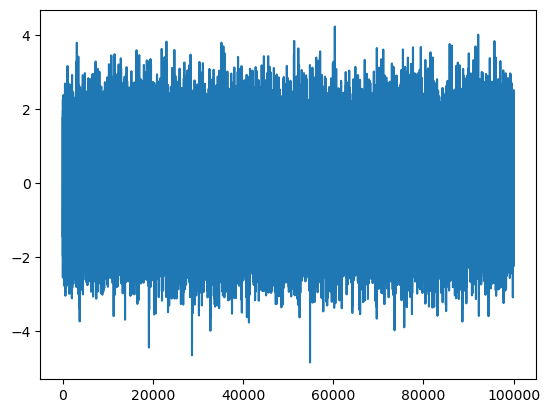

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats.distributions import chi2

N = 100000
np.random.seed(0)
a = np.random.randn(N)
plt.plot(a)

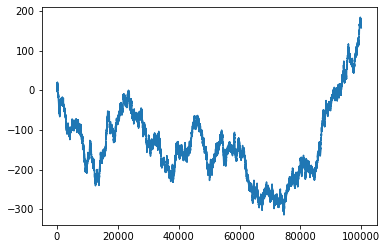

In [104]:
# Now define red data with an autoregressive process
b = np.empty_like(a)
b[0] = a[0]
for i in range(1,N):
    b[i] = b[i-1] + a[i]
    
plt.plot(b)

In [8]:
def autocorr(x, norm=True, twosided=False, unbiased=False):
    """
    Based on Eric Firing's Lecture notes
    
    Return (lags, ac), where ac is the estimated autocorrelation 
    function for x, at the full set of possible lags.
    
    If norm is True, the covariance at lag zero is normalized to 1 
    
    If twosided is True, all lags will be included;
    otherwise (default), only non-negative lags will be included.

    If unbiased is True, the low-MSE estimate, linearly
    tapered to zero for large lags, is returned.
    """
    N = len(x)
    xdm = x - x.mean()
    ac = np.correlate(xdm, xdm, mode='full')
    if norm:
        ac /= ac[N - 1]
    lags = np.arange(-N + 1, N)
    if unbiased:  # undo the built-in normalization
        taper = 1 - np.abs(lags) / float(N)
        ac /= taper
    if twosided:
        return lags, ac
    else:
        return lags[N-1:], ac[N-1:]

In [50]:
# Let's first do the autocorrelation of the white noise time series
lags_whitenoise , ac_whitenoise = autocorr(a, norm=True, twosided=True, unbiased=False)
_, ac_whitenoise_unbiased = autocorr(a, norm=True, twosided=True, unbiased=True)

In [51]:
lags , ac = autocorr(b, norm=True, twosided=True, unbiased=False)
_, ac_unbiased = autocorr(b, norm=True, twosided=True, unbiased=True)

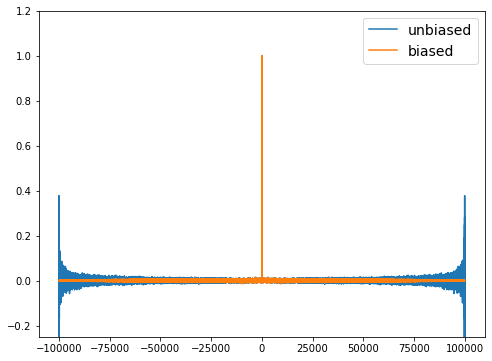

In [100]:
plt.figure(figsize=(8, 6))
plt.plot(lags, ac_whitenoise_unbiased, label='unbiased')
plt.plot(lags, ac_whitenoise, label='biased')
plt.ylim([-.25,1.2])
plt.legend(loc=1, fontsize=14)

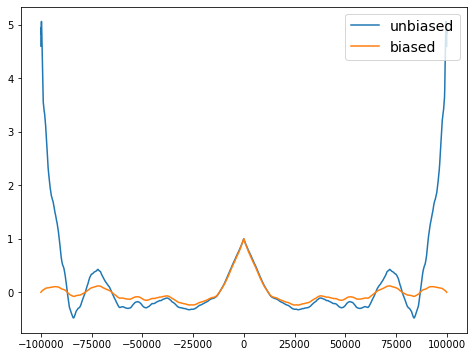

In [53]:
plt.figure(figsize=(8, 6))
plt.plot(lags, ac_unbiased, label='unbiased')
plt.plot(lags, ac, label='biased')
plt.legend(loc=1, fontsize=14)

#### Biased vs unbiased estimators.

Notice that we  could consider both the "biased" and  the "unbiased" estimator.  There are arguments
for either choice.  The difference depends on how we
normalize our discrete autocovariance.  In the unbiased case, we're computing

$$\begin{equation}
R(\tau)_{unbiased} = \frac{1}{N-m}\sum_{n=1}^{N-m} x(t_n)x(t_{n+m}),
\end{equation}$$

Where $\tau=m\Delta t$ is the $m$-sample lag.  In the biased case, we change how we normalize:

$$\begin{equation}
R(\tau)_{biased} = \frac{1}{N}\sum_{n=1}^{N} x(t_n)x(t_{n+m}), \hspace{3cm} (24)
\end{equation}$$

which means that as the number of values we consider becomes smaller, we constrain the
magnitude of the autocovariance by continuing to divide by $N$.  Emery and Thomson note that
the biased estimator acts like a triangle window.

**For spectra, you will want to stick to the unbiased estimator,
and then choose your own window carefully.**

#### Practical implementation:  Spectra from auto-covariance

Using the auto-covariance to compute spectra requires averaging, just as we did
by segmenting our data and using the fft, but there's one tidy little trick.  Let's
use some white noise again, and take a look at our options:

1. Suppose we start with a big matrix of white noise, and we compute the autocovariance for each column of our matrix, then Fourier transform, and use these to compute a spectrum.  To be concrete about our frequencies, let's assume we have data sampled every one second.  We'll end up doing something along these lines:

In [54]:
M = 100
N = 1000
A = np.random.randn(M, N)
auto_cor = np.empty((M, 2*N-1))
for i in range(M):
    _, auto_cor[i] = autocorr(A[i], norm=True, twosided=True, unbiased=True)
fft_auto_cor = np.fft.fft(auto_cor[:,500:1500], axis=1)

Text(0, 0.5, 'Spectral energy ([time series units]^2/Hz)')

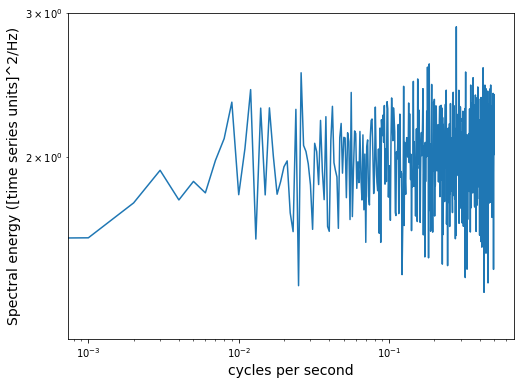

In [56]:
frequency = np.arange(0,501)/N
plt.figure(figsize=(8,6))
plt.loglog(frequency, 2*abs(np.mean(fft_auto_cor[:,0:501], axis=0)))
plt.ylim([1.2,3])
plt.xlabel('cycles per second', fontsize=14)
plt.ylabel('Spectral energy ([time series units]^2/Hz)', fontsize=14)

As with the standard Welch method for spectral estimation (which we can properly refer to as a “periodogram”), we’re only plotting half the spectrum, so we need double the energy.

We can do a quick verification of Parseval's theorem by noting that the (white) spectrum has a level of about 2, and our Nyquist frequency is 0.5, so the integral of the spectrum (which is just $\Phi f_N$) gives the expected variance of one.

2. Alternatively, we could average all of the autocovariances, and then Fourier transform:

In [57]:
mean_auto = np.mean(auto_cor, axis=0)
fft_auto_mean = np.fft.fft(mean_auto[500:1500])

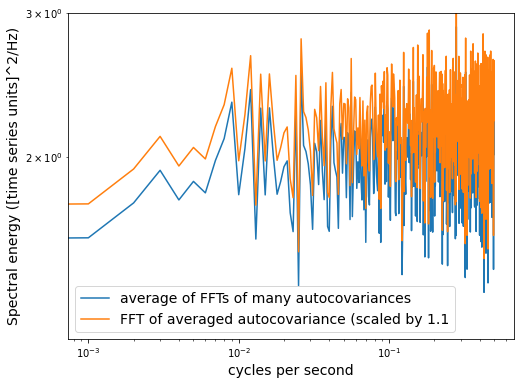

In [58]:
plt.figure(figsize=(8,6))
plt.loglog(frequency, 2*abs(np.mean(fft_auto_cor[:,0:501], axis=0)), label='average of FFTs of many autocovariances')
plt.loglog(frequency, 2*abs(fft_auto_mean[0:501])*1.1, label='FFT of averaged autocovariance (scaled by 1.1')
plt.ylim([1.2, 3])
plt.xlabel('cycles per second', fontsize=14)
plt.ylabel('Spectral energy ([time series units]^2/Hz)', fontsize=14)
plt.legend(fontsize=14)

3. For comparison, the peridogram-based determined from the fft of the data:

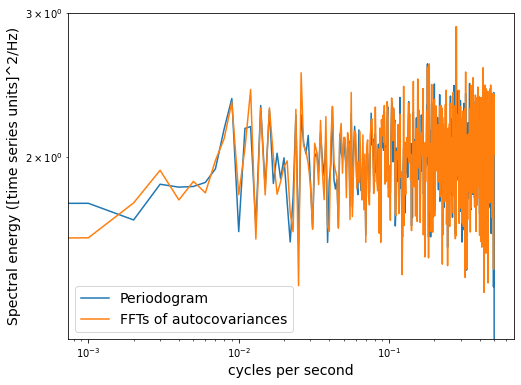

In [59]:
fA = np.fft.fft(A, axis=1)
ampA = abs(fA[:, :501])**2/N 
ampA[:,1:-1] = 2*ampA[:,1:-1]

plt.figure(figsize=(8,6))
plt.loglog(frequency, np.mean(ampA, axis=0), label = 'Periodogram')
plt.loglog(frequency, 2*abs(np.mean(fft_auto_cor[:,0:501], axis=0)), label='FFTs of autocovariances')

plt.ylim([1.2, 3])
plt.xlabel('cycles per second', fontsize=14)
plt.ylabel('Spectral energy ([time series units]^2/Hz)', fontsize=14)
plt.legend(loc=3, fontsize=14)

4. Finally, you might skip all segmenting and just compute the autocovariance of the full (100,000 value) record, and then FFT only a subset:

Text(0, 0.5, 'Spectral energy ([time series units]^2/Hz)')

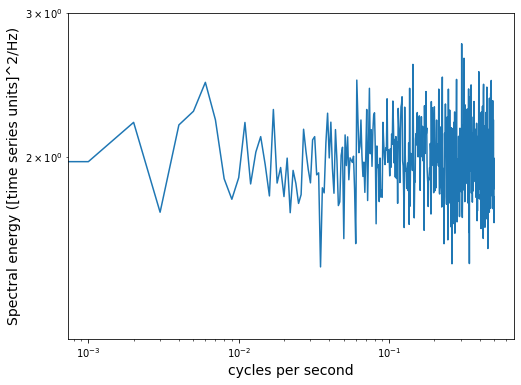

In [60]:
na = len(a)

lags, aca = autocorr(a, norm=True, twosided=True, unbiased=False)
faca = np.fft.fft(aca[na-500:na+501])

plt.figure(figsize=(8,6))
plt.loglog(frequency, 2*abs(faca[:501]))
plt.ylim([1.2, 3])

plt.xlabel('cycles per second', fontsize=14)
plt.ylabel('Spectral energy ([time series units]^2/Hz)', fontsize=14)

In the results, shown in Figure 1, the curves (for options 1 and 2) are identical, though the orange line has been scaled up by 10\% to make both visible. 

You shouldn't be surprised that averaging before or after the FFT leads to the same results,
since averaging has no impact on the FFT.  This might
give you ideas of how you can take advantage of the autocovariance to compute spectra
from gappy data.
Importantly,
we can compute spectra without needing to chunk our data and
compute lots of ffts, provided that we had a good estimate of the autocovariance.

The best estimate of the autocovariance should have the most averaging, and
you can maximize your averages by using the longest possible records (option 4
above).
Suppose you have 1000 data points, and two possible ways to analyze the
data.

- If you split the record into 10 segments of 100 points, the zero-lag autocovariance will be an average of 1000 points, which is great, but the lag 100 autocovariance will represent an average of only 10 points, which is not so great.

- In contrast, if you don't split the record, the zero-lag autocovariance will still be an average of 1000 points, while the lag 100 auto-covariance will be an average of 900 points, on the whole a lot more averaging.

In the days before the development of the FFT, the autocovariance was a natural pathway to
determining the spectrum, since it was clean and easy to compute.
And now, with modern computing, you might not feel like there's any need to take
advantage of the FFT anymore.
If you can obtain the best possible estimate of the autocovariance,
by whatever means necessary, then you should be able to compute one FFT and obtain reasonable
estimate of the spectrum, without concern for data gaps or computational speed.

Formally if you compute spectra from the autocovariance, you need to think about averaging just
as thoroughly as you do for segmented windowed data (through the Welch method) or for frequency-averaged
spectra (the Daniell method).  In this case, the challenge comes in deciding what fraction of the autocovariance
to actually Fourier transform.  If you use the autocovariance over the entire data range, your autocovariance
estimator has too much uncertainty at the large lags, and the resulting spectrum will have large uncertainties.

I hope you can see the parallel with Welch's method: to gain better spectral precision, we have to give up resolution of the lowest frequencies in both cases.  In Welch's method, it's because the length of each chunk is shorter so the fundamental frequency is higher.  With this method, we lose information on the lowest frequencies because we're throwing out the longer lags.  It seems like we're throwing out information, but the autocovariance has all the information packed into the lags of interest.


When we use the autocovariance to compute spectra, we'll want to
omit the poorly sampled edges of the spectrum.  There are a number of ways to
do this.   We have to decide what fraction of the autocovariance
to use.  For example I could take half, or a quarter.  What difference
does it make?  In essence, the fraction that I use determines the
amount of averaging that I do, and therefore defines the number
of degrees of freedom.  In the simplest form, we use a boxcar window
to extract values (where we're switching to the red spectrum just for variety):

In [1]:
nb = len(b) 
M = nb//8 # half width of points to use
print(M)
fny=0.5;
fBB = np.fft.fft(ac[nb-M+1:nb+M]) 
#nb is the index of the center point of ac
# since the fft assumes the record to
# be circular, remove one point at the end 
plt.figure(figsize=(8,6))
plt.loglog(np.arange(0,M)/M*fny, abs(fBB[1:M+1]))
plt.xlabel('cycles per second', fontsize=14)
plt.ylabel('Spectral energy ([time series units]^2/Hz)', fontsize=14)

NameError: name 'b' is not defined

The degrees of freedom are determined by the width of the window.
If I have $N$ data points, and I use $M$ of them in the Fourier transform,
then I'm implicitly averaging $N/M$ independent samples, which gives me
$N/M$ degrees of freedom.   I can compute an error bar based on this in
exactly the way that we did earlier for the periodogram approach:

In [117]:
nu = nb/M
print(nu)
error_high = nu/chi2.ppf(0.05/2, df=nu)
error_low = nu/chi2.ppf(1-0.05/2, df=nu)

4.0


Text(0, 0.5, 'Spectral energy ([time series units]^2/Hz)')

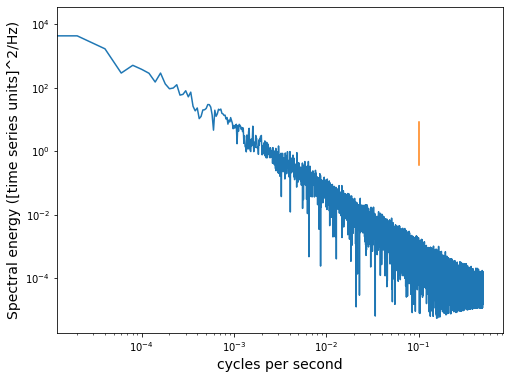

In [122]:
plt.figure(figsize=(8,6))
plt.loglog(np.arange(0,M)/M*fny, abs(fBB[1:M+1]))
plt.loglog([1e-1, 1e-1], [error_low, error_high])
plt.xlabel('cycles per second', fontsize=14)
plt.ylabel('Spectral energy ([time series units]^2/Hz)', fontsize=14)

Now remember: truncating the autocovariance is the same thing as multiplying it by a boxcar, which as we know causes the spectral estimate to be multiplied by $sinc(f)$ (not $sinc^2(f)$!).  So you might decide that a boxcar windowed view of the autocovariance is
likely to have unfortunate characteristics in the Fourier domain, in which
case you could use a different window instead:  a triangle window (also called a Bartlett window), or a Hanning window, or a Hamming window.  For example:

In [124]:
fBB_box = np.fft.fft(ac[nb-M:nb+M+1])
#fBB_t = np.fft.fft(ac[nb-M:nb+M+1]*np.bartlett(2*M+1))
fBB_h = np.fft.fft(ac[nb-M:nb+M+1]*np.hanning(2*M+1))

Text(0, 0.5, 'Spectral energy ([time series units]^2/Hz)')

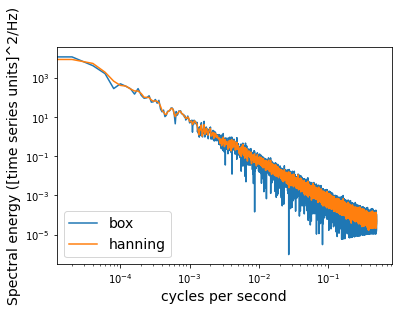

In [125]:
plt.loglog(np.arange(0, M)/M*fny, abs(fBB_box[:M]),label='box') 
plt.loglog(np.arange(0, M)/M*fny, abs(fBB_h[:M]),label='hanning') 
plt.legend(loc=3, fontsize=14)
plt.xlabel('cycles per second', fontsize=14)
plt.ylabel('Spectral energy ([time series units]^2/Hz)', fontsize=14)

In this case we adjust the error bars to account for the windowing of
the autocovariance.  As it turns out, the table (5.5 in Thomson and
Emery, 2014)
that was so misleading for overlapping segmented data is exactly
what we need here:


| Window type | Equivalent degrees of freedom ($\nu$) |
| :-------------: | :----------: | 
| Truncated peridogram (boxcar) | $N/M$ 
| Bartlett (triangle) | $3N/M$ 
| Daniell (sinc) | $2N/M$ 
| Parzen  | $3.708614 N/M$
| Hanning | $8/3 N/M$
| Hamming | $2.5164 N/M$


This works well when $M$ is small compared with $N$ and when the autocovariance is comparatively narrow.  In other words, for white noise, this converges nicely; for a broad red noise peak, the autocovariance tends to have
negative lobes, making the choice of $M$ difficult and the results
not amenable to interpretation.
The challenge in dealing with the truncation of the autocovariance
is perhaps the reason that although this approach is often presented
in equations (in
idealized cases with infinite data), it is less frequently implemented for real
applications.

#### Side bar:  Autocovariance in discrete form.

Last time we went through the representation of the autocovariance using an integral form.  Let's  rewrite this in terms of the discrete Fourier transform.  In this case, the mean
of our data is:

\begin{equation}
\langle x\rangle = \frac{1}{2T} \int_{-T}^T x(t) e^{i0}\, dt = a_0. \hspace{3cm} (25)
\end{equation}

and the variance is

\begin{equation}
\langle x*x\rangle =  \frac{1}{2T} \int_{-T}^T x^*(t) x(t)\, dt - |a_0|^2. \hspace{3cm} (26)
\end{equation}

We use the complex conjugate here, just in case $x(t)$ is represented as a complex number,
since this will give us the sum of the squares.
Notice that we've remembered to subtract out the mean (our frequency
zero Fourier coefficient).


In similar notation, we can write the covariance (for finite record length
$2T$) as:

\begin{equation}
R(\tau)=  \frac{1}{2T} \int_{-T}^T x^*(t) x(t+\tau)\, dt - |a_0|^2. \hspace{3cm} (27)
\end{equation}

This lets us write out an expression for the variance ${R}$
in terms of the discrete
Fourier coefficients:

\begin{eqnarray}
{R}(\tau)& = & \frac{1}{2T} \int_{-T}^T \left[ \sum_{n=-\infty}^\infty a_n^* e^{-i2\pi f_n t}
\sum_{m=-\infty}^\infty a_m e^{i2\pi f_m (t+\tau)}\right]\, dt - |a_0|^2 \hspace{3cm} (28)\\
& = & \sum_{n=-\infty}^\infty \sum_{m=-\infty}^\infty a_n^* a_m e^{+i2\pi f_m \tau}\frac{1}{2T}\int_{-T}^T
 e^{i(-2\pi f_n + 2\pi f_m) t} \, dt - |a_0|^2 \hspace{3cm} (29)\\
& = & \sum_{m=-\infty}^\infty |a_m|^2  e^{+i2\pi f_m \tau} - |a_0|^2 \hspace{3cm} (30)
\end{eqnarray}

where we used a Kronecker delta ($\delta_{nm}$) to eliminate the integral
with $ e^{2\pi i(-f_n + f_m) t}$ except when $n=m$, and we subtracted
$a_0^2$ at the end to match our original definition.
In setting this up, recall (from lecture 5) that the Fourier transform uses $e^{-i2\pi ft}$, and the
inverse transform uses $e^{+i2\pi ft}$.  We're using the inverse transform here (though the signs reversed
when we had the complex conjugate.
This tells us that the Fourier transform of the autocovariance can
be expressed by the squared Fourier coefficients.  (So we could avoid
the Fourier transform completely and just work with the auto-covariance.)

In this form, Parseval's theorem simply says that

\begin{eqnarray}
{R}(0)& = & \frac{1}{2T} \int_{-T}^T x^*(t) x(t+0)\, dt - |a_0|^2 \hspace{3cm} (31)\\
& = & \sum_{m=-\infty}^\infty |a_m|^2 - |a_0|^2 \hspace{3cm} (32)
\end{eqnarray}

meaning that the variance of $x$ is the sum of magnitudes of the
Fourier coefficients.

#### Other spectral methods

We will not cover these methods in this class, but I want to make you at least aware of a class of spectral estimation techniques known as *parametric* spectral estimators.  Here, rather than computing the spectrum directly, we try to estimate a function that satisfies some criterion.  These methods include 

1. Maximum entropy 
2. Maximum likelihood

As well as another direct estimator:

3. Multitaper

These are all described in Emery and Thomson 5.7, and also in Percival (2020) which I've put on Canvas. We'll go over multi-taper spectra a bit here.


*Multi-tapers and spectral peaks*

Spectra can come in two flavors.  Some have distinct single peaks, associated with
tides.  Some have large-scale structure associated with the general red structure of the ocean. If we want to find exactly the right peaks, then we can try different strategies to what we use when we want to find the general structure.

When we have narrow peaks, they aren't always easy to differentiate, particularly if our
sampling is a bit coarse compared with the signals we'd like to detect.
Consider the following case of a sinusoidal cycle that might or might
not be well sampled, depending how long our instruments survive:

In [ ]:
time=1:.5:120;
A=2*cos(2*pi*time/30)+cos(2*pi*time/60);
B=A(1:200);
C=[A(1:200) zeros(1,40)];

plot(time,A,time(1:200),B,'LineWidth',3)
set(gca,'FontSize',16)
xlabel('time','FontSize',16)
ylabel('amplitude','FontSize',16)

fA=fft(A);
fB=fft(B);
fC=fft(C);

frequency1=(0:120)/120;
frequency2=(0:100)/100;

loglog(frequency1,abs(fA(1:121)).^2,frequency2,abs(fB(1:101)).^2,...
  frequency1,abs(fC(1:121)).^2,'LineWidth',3)
set(gca,'FontSize',16)
xlabel('frequency','FontSize',16)
ylabel('spectral density','FontSize',16)
legend('full record','truncated record','zero padding')

When you look at this example, you might conclude that without perfect
sampling of full sinusoidal cycles, we'll never find the correct spectral
peaks.  In essence this is a windowing problem.
When we have narrow peaks, they aren't always easy to differentiate, particularly if our
sampling is a bit coarse compared with the signals we'd like to detect. 

If we don't have adequate resolution what are our options?

* Possibility 1.  Pad the short record with zeros to make it as long as we want.  Since
resolution is $f=1/(N\Delta t)$.  In this case, we'll see the impact of a sinc function
bleeding into the frequencies that we'd like to resolve.  Clearly this doesn't fully solve
our problem.
* Possibility 2.  Obtain a longer record.  This will be critical if we really want to resolve our signal.

Even if our record is norminally long enough, we also need to figure out how to optimize
our detection of spectral peaks.  Earlier we looked at the impact of windows, and examples
from the Harris (1978) study showed how much impact a good windowing strategy can have
in identifying spectral peaks.  (For continuous spectra, windowing approaches work well.)

Formally, you'll recall that we can represent our record length
problems using a convolution of our data with a finite width filter:
\begin{equation}
\hat{X}(f_n) = \int_{-\infty}^{\infty} X(f_m)W(f_n-f_m)\, df_m,
\end{equation}
where
\begin{equation}
W(f) = \frac{\sin(2\pi f T)}{2\pi f T} = \text{sinc}\left(2\pi f T\right)
\end{equation}
This means that the spectrum is essentially convolved with $W(2\pi f T)^2$.
But as we noted earlier, we can switch from a boxcar window to a triangle
window or something a bit more Gaussian than that and cut down on the
sidelobes in our window to obtain a cleaner spectrum, although we have to
widen the central peak of the window in the frequency domain, which
means de-emphaizing the beginning and end of the data series.

What if we want to improve our resolution.  Consider the example
of a record equivalent to
\begin{equation}
x=100\cos(2\pi 20.5/10001)+80\cos(2\pi 30.4/100001) + 100\cos(2\pi 40.8/100001)
+ 10\cos(2\pi 50.3/100001)
\end{equation}
The quality of our spectral estimate will depend on the length of our record.
(Why is that?  The resolution is the lowest resolved frequency.)  So what can
we do to improve resolution.  One strategy would be to pad our record
with zeros to make it as long we want.  That buys us something, but it
gives us plenty of spectral ringing.

If we want to optimize resolution, we can try a multitaper approach.  (See for example
Ghil et al, Reviews of Geophysics, 2001).  In a multitaper approach, we replace our single
window with a set of tapers.  The tapers are designed to minimize spectral leakage, and
they are referred to as "discrete prolate spheroidal sequences" or "Slepian" tapers
(after Slepian, who studied them).  Tapers are what we've been calling  windows---they pre-multiply the data,
Fourier transforms are computed, and then the spectrum is computed as a weighted sum of
all of the squared Fourier transforms.  This effectively averages over an ensemble of windows to minimize
variance.  This is very effective for extracting narrow peaks that would otherwise be
undetectable.
Matlab has a multi-taper method package ("pmtm"), but if you really want this to work, you probably want to dig into the guts of the algorithm a bit further.

Here's the Matlab example, modified slightly to make a longer record:

In [ ]:
fs = 1000;                % Sampling frequency
t = (0:3*fs)/fs;            % One second worth of samples
A = [1 2];                % Sinusoid amplitudes
f = [150;140];            % Sinusoid frequencies

xn = A*sin(2*pi*f*t) + 0.1*randn(size(t));
pmtm(xn,4,[],fs)

This produces an impressive two spectral peaks.  Of course this example isn't
too tricky.  Here's what we get if we take the same data and split them into
6 non-overlapping segments, even with no windowing or detrending:

In [ ]:
fa=fft(reshape(xn(1:3000),500,6));
semilogy(mean(abs(fa(1:250,:)').^2))

These are reassuringly similar results.